# BOX-Snd RUN

In [1]:
import openmc
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import kdsource as kds
from mpl_toolkits.mplot3d import Axes3D as ax

#### Biblioteca de secciones eficaces

In [2]:
openmc_data = "/home/agusgimenez/KD_OPMC/Secciones/endfb-vii.1-hdf5/cross_sections.xml"
os.environ["OPENMC_CROSS_SECTIONS"] = openmc_data
openmc.config['cross_sections'] = openmc_data

### MATERIALES

In [3]:


mat01 = openmc.Material(material_id=0) #agua
mat01.add_nuclide('H1',2.000,'ao')
mat01.add_nuclide('O16',0.9976,'ao')
mat01.add_nuclide('O17',0.00035,'ao')
mat01.add_s_alpha_beta('c_H_in_H2O')
mat01.set_density('g/cm3',1.00)


mat02 = openmc.Material(material_id=1)
mat02.add_nuclide('Cd106',1.22,'ao')
mat02.add_nuclide('Cd108',0.88,'ao')
mat02.add_nuclide('Cd110',12.39,'ao')
mat02.add_nuclide('Cd111',12.75,'ao')
mat02.add_nuclide('Cd112',24.07,'ao')
mat02.add_nuclide('Cd113',12.26,'ao')
mat02.add_nuclide('Cd114',28.86,'ao')
mat02.add_nuclide('Cd116',7.58,'ao')

mat02.set_density('g/cm3',8.65)

### PARAMETROS DE GEOMETRIAS

In [4]:

#bloque mat01
W =5.0 #semi-ancho
H =5.0 #semi-alto
L =1.0 #largo 

#bloque donde quiero ver la lista de particulas
angle = math.radians(30)

#FUENTE
R = 1.0


### GEOMETRIAS

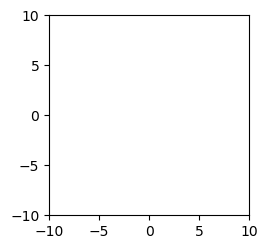

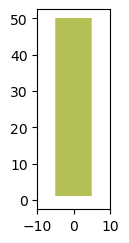

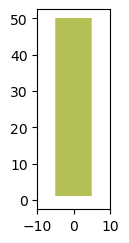

In [5]:

#bloque mat01
surf1 = openmc.XPlane(-W-0.01*L)
surf1.boundary_type = 'vacuum'

surf6 = openmc.XPlane(W+0.01*L)
surf6.boundary_type = 'vacuum'

surf2 = openmc.YPlane(-H-0.01*L)
surf2.boundary_type = 'vacuum'

surf5 = openmc.YPlane(H+0.01*L)
surf5.boundary_type = 'vacuum'


surf3 = openmc.ZPlane(0)
surf3.boundary_type = 'vacuum'

surf4 = openmc.ZPlane(L-0.01*L)
surf4.boundary_type = 'vacuum'

surf7 = openmc.ZPlane(50*L)
surf7.boundary_type = 'vacuum'



cell00 = openmc.Cell(fill=None,cell_id=0)
cell00.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf4 & -surf7

# cell01 = openmc.Cell(fill=mat01,cell_id=1)
# cell01.region = +surf1 & -surf6 & +surf2 & -surf5 & +surf3 & -surf4


#source.hs
surf_source = openmc.Plane.from_points((-W,-H,L),(-W,H,L),(0.0,0.0,L+W*math.sin(angle)/math.cos(angle)))
surf_source.boundary_type = 'vacuum'
cell02 = openmc.Cell(fill=None,cell_id=2)
cell02.region = -surf7 & -surf_source & +surf1 & -surf6 & +surf2 & -surf5


univ01 = openmc.Universe(cells=[cell00],universe_id=1) 
univ01.plot(origin=(0.0,0.0,L/2),width=(4*W,4*W))
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='yz')
univ01.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='xz')



# univ02 = openmc.Universe(cells=[cell02],universe_id=2) 
# univ02.plot(origin=(0.0,0.0,L/2),width=(4*W,4*W))
# univ02.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='yz')
# univ02.plot(origin=(0.0,0.0,50*L/2),width=(4*W,55*L),basis='xz')


### PARAMETROS DE EJECUCION

In [6]:
#Numero de particulas 
N = int(1E7)


param_resampled = openmc.Settings()
param_resampled.source = openmc.Source(filename='plano_1_resampled.h5')
# param_resampled.source = openmc.Source(filename='plano_2_resampled.h5')
param_resampled.run_mode = "fixed source"
param_resampled.batches = 1
param_resampled.particles = N

superficies = [surf7.id]

param_resampled.surf_source_write = {
    'surface_ids': superficies,
    'max_particles': len(superficies)*N
}

param_resampled.source = openmc.Compiled

### GENERACION DE ARCHIVOS XML

In [7]:
geom = openmc.Geometry(univ01)
# geom = openmc.Geometry(univ02)
geom.export_to_xml()

mats = openmc.Materials(univ01.get_all_materials().values())
mats.cross_sections = openmc_data
mats.export_to_xml()

param_resampled.export_to_xml()




In [8]:
!rm statepoint.*.h5
!rm summary.h5
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################